# Taller de Visión por Computador: Sistema de recuperación de imagenes con CLIP sobre CALTECH 256)
**Fecha:** 06 de junio de 2025

Este notebook implementa el modelo preentrenado CLIP como generador de embeddings tanto de imagen como de texto

## 0. Requisitos y Configuración Inicial

In [ ]:
# 📌 0. Requisitos y Configuración Inicial

# 0.1. Instalación de librerías
# Si no tienes las librerías instaladas, descomenta y ejecuta la siguiente línea:
# !pip install -r requirements.txt

# 0.2. Importación de librerías
import clip
import torch
from PIL import Image
import os
import numpy as np
import random
import os
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
# 0.2. Cargar modelo CLIP
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device)


## 1. Carga y Preparación del Dataset CALTECH 256

In [ ]:


# 1.1 Función para cargar imágenes desde subcarpetas, toma un cuarto de los datos de cada carpeta
def load_images_from_subfolders(base_dir):
    images = []
    image_paths = []
    
    for root, dirs, files in os.walk(base_dir):
        for file in files[:int(len(files)/4)]:
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Asegúrate de que sean imágenes válidas
                img_path = os.path.join(root, file)
                image_paths.append(img_path)
                
                # Usamos el bloque 'with' para garantizar que la imagen se cierre después de abrirla
                with Image.open(img_path) as img:
                    images.append(img.copy())  # Usamos .copy() para asegurarnos de que la imagen no se cierre prematuramente
    
    return images, image_paths

# Cargar imágenes de la carpeta 256_ObjectCategories
base_dir = '256_ObjectCategories'
images, image_paths = load_images_from_subfolders(base_dir)

# Verificar cuántas imágenes se cargaron
print(f"Se cargaron {len(images)} imágenes")



Se cargaron 7557 imágenes


## 2. Generacion de la base vectorial (Embeddings de las imagenes)

In [ ]:

# 2.1 Función para generar embeddings de imágenes
def generate_image_embeddings(images):
    image_embeddings = []
    
    for image in images:
        
        # Preprocesar y generar el embedding de la imagen
        image_input = preprocess(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            image_features = model.encode_image(image_input)
        
        image_embeddings.append(image_features.cpu().numpy())
    
    return np.array(image_embeddings)

# Generar los embeddings de las imágenes
image_embeddings = generate_image_embeddings(images)


## 3. Generacion de embeddings de Texto

In [7]:
# 3.1 Función para generar el embedding de una consulta de texto
def get_text_embedding(text):
    text_input = clip.tokenize([text]).to(device)
    
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    
    return text_features.cpu().numpy()

# Ejemplo de texto de consulta
query_text = "a picture of a blue flag"

# Generar el embedding del texto
text_embedding = get_text_embedding(query_text)


## 4. Comparacion de embeddings de texto con imagenes mediante la similitud coseno

In [ ]:



# 4.1 Función para realizar la búsqueda de imágenes más similares
def search_images_by_text(query_text, image_embeddings, image_paths):
    # Obtener el embedding de la consulta de texto
    text_embedding = get_text_embedding(query_text)
    
    # Asegurarse de que el embedding de texto sea 2D
    text_embedding = text_embedding.reshape(1, -1)
    
    # Asegurarse de que los embeddings de imagen sean 2D
    image_embeddings = image_embeddings.reshape(len(image_embeddings), -1)
    
    # Calcular la similitud coseno entre el texto y las imágenes
    similarities = cosine_similarity(text_embedding, image_embeddings)
    
    # Ordenar las imágenes según la similitud (de mayor a menor)
    sorted_indices = np.argsort(similarities[0])[::-1]
    
    # Devolver las rutas de las imágenes más similares
    return [image_paths[i] for i in sorted_indices]




## 5. Ejecucion de todo el sistema de recuperación

Query: Real Dog


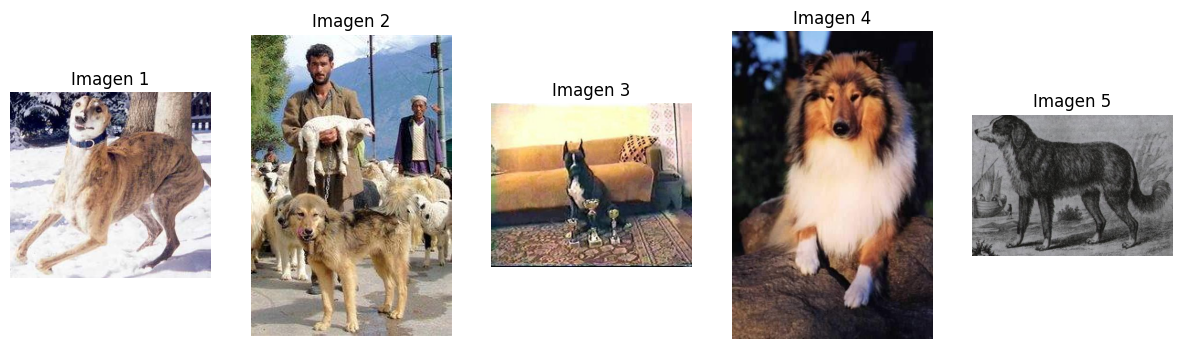

In [15]:
# Realizar la búsqueda de imágenes más similares
query_text="Real Dog"
sorted_image_paths = search_images_by_text(query_text, image_embeddings, image_paths)
plt.figure(figsize=(15, 10))
print("Query:",query_text)
for i in range(5):
    img = Image.open(sorted_image_paths[i])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Imagen {i+1}")
plt.show()


Query: Cute small dog


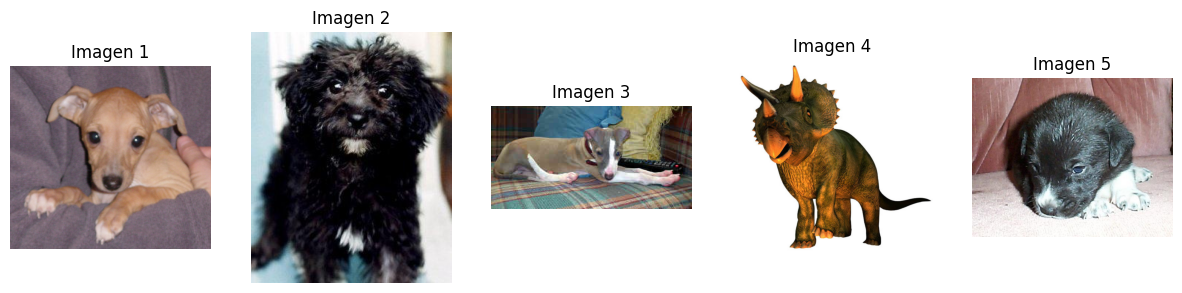

In [13]:
query_text="Cute small dog"

sorted_image_paths = search_images_by_text(query_text, image_embeddings, image_paths)
plt.figure(figsize=(15, 10))
print("Query:",query_text)
for i in range(5):
    img = Image.open(sorted_image_paths[i])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Imagen {i+1}")
plt.show()


Query: cute white small dog


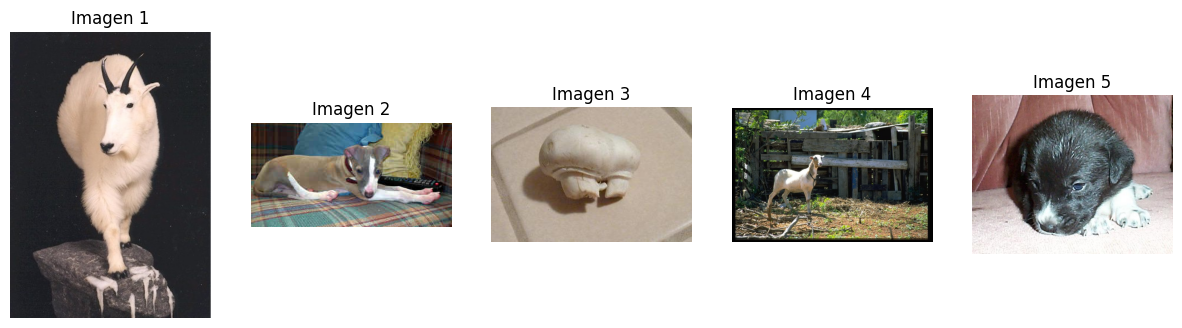

In [18]:
query_text="cute white small dog"

sorted_image_paths = search_images_by_text(query_text, image_embeddings, image_paths)
plt.figure(figsize=(15, 10))
print("Query:",query_text)
for i in range(5):
    img = Image.open(sorted_image_paths[i])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Imagen {i+1}")
plt.show()

Query: Wild life animals


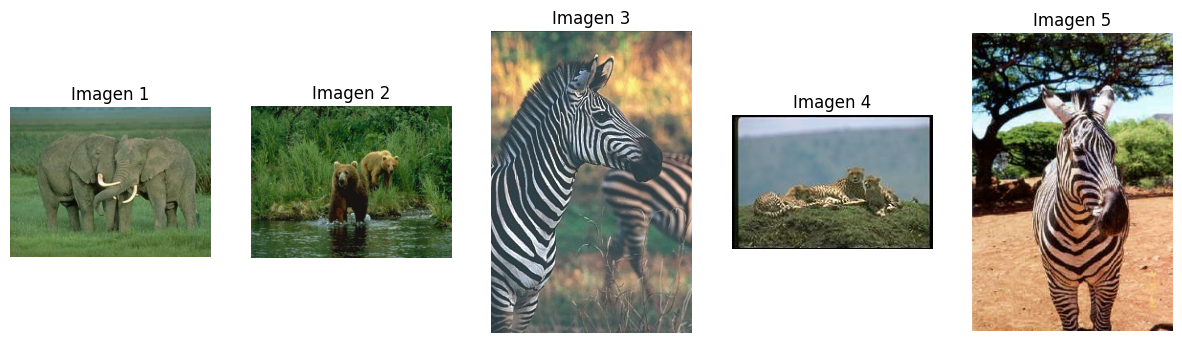

In [21]:
query_text="Wild life animals"

sorted_image_paths = search_images_by_text(query_text, image_embeddings, image_paths)
plt.figure(figsize=(15, 10))
print("Query:",query_text)
for i in range(5):
    img = Image.open(sorted_image_paths[i])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Imagen {i+1}")
plt.show()

## Conclusiones

-El sistema de recuperacion de información funciona bien para queries sencillas, se probaron 4 queries:  

    *En la primera query, "Real Dog", todos los ejemplos obtenidos corresponden a la consulta de texto,
    *En la segunda query, "Cute small dog", la cuarta imagen más similar no corresponde a un perro,
    *En la segunda query, "cute white small dog", las imagenes no coinciden con la querie,

-Para queries mas tematicos como "wild life animals" el sistema funciona bien, esto indica que CLIP es capaz de extraer contenido tematico de las imagenes.

-Crear la base de datos vectorial con menos imagenes afecta directamente al sistema de recuperación porque con más imagenes hay más probabilidad de traer una mejor imagen para una querie